# Peak to peak: Amplitude of the Seasonal Cycle

On this notebook we find described the code used to get a plot of the (mean) amplitude of the seasonal cycle of the mixed layer depth in the regions named in the notebook [Regions](./Distribution-regions.ipynb). 

For the sake of brevity, the notebook only considers one example for one of the subregions, the Nordic Sea. This notebook has the following structure:

   [1. Imported modules](#1.-Imported-modules)
   [2. Dictionaries used](#2.-Dictionaries-used)
   [3. Functions](#3.-Functions)
   [4. Example plot](#4.-Example-plot)
    
Figures of this kind can be found in the written report [MLD project](https://www.overleaf.com/read/rmjfbdbbrsbf
), in the Section (3.2.2), (4.2.2), (5.2.2) and Chapter 6.

The Nordic Sea was chosen to plot here in order to have the algorithm to obtain the region using a non rectangular projection.

## 1. Imported modules

In [1]:
import xarray as xr
import numpy as np
import datetime
import pandas as pd
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath



import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.animation as animation
from IPython.display import HTML

import warnings; warnings.simplefilter('ignore')

## 2. Dictionaries used

In [2]:
"""
subregions is a dictionary that has the coordinate
boundaries of the sub-regions. The format is:
<subregion> :
  <lon> : (lon1, lon2)
  <lat> : (lat1,  lat2)
  <name> : title for an eventual ploting title
"""

subregions = {
    'lab': {
        'lon' : (-55, -51),
        'lat' : (56, 59),
        'name' : 'Labrador Sea'
    },
    'irm': {
        'lon' : (-39, -35),
        'lat' : (58, 61),
        'name' : 'Irminger Sea'
    },
    'gul': {
        'lon' : (-57, -53),
        'lat' : (34, 38),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-20, -16),
        'lat' : (50, 53),
        'name' : 'North East Sea'
    },
    'nor1': {
        'lon' : (-2, 2),
        'lat' : (73, 76),
        'name' : 'Nordic Sea- Northern'
    },
    'nor2': {
        'lon' : (0, 4),
        'lat' : (68, 71),
        'name' : 'Nordic Sea- Southern'
    }   
}


"""
reg_ext is a dictionary that has the coordinate
boundaries of the main regions. The format is:
<region> :
  <lon> : (lon1, lon2)
  <lat> : (lat1,  lat2)
  <name> : title for an eventual ploting title
"""

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-25, 20),
        'lat' : (65, 80),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 50.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}


## 3. Functions

In [3]:
## Function to crop the dataset
def Crops(coord, d_set):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    name_fig = reg_ext[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)


def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)

def Map(ax, region, xtick, ytick):
    """
        Map is a function that helps to plot the map on a certain projection
        of a region. It always uses 50m definition of coastlines. In Cartopy 
        0.16.0 it is not possible to use xticks and yticks for non-rectangular
        projections, this function is available for Cartopy 0.18.0

        Parameters:
        ------------
        ax : axes
            Current axes object in which is drawn the map.

        region : list
            Set of limit coordinates of the region to plot.
            It has the shape [lon1, lon2, lat1, lat2]

        xtick : np.array
            array containing the number and spacement of ticks 
            in x-axis.

        ytick : np.array
            Array containing the number and spacement of ticks 
            in y-axis.
    """
    ax.set_global()
    ax.coastlines('50m')
    #ax.set_xticks(xtick, crs=ccrs.PlateCarree())  
    #ax.set_yticks(ytick, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')



def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)

## 4. Example plot

In [4]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################

dir_1 = '../../../New_ARMOR/'
dir_15 = '/net/data0-gw/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'

dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'


fl_n1 = 'NARMOR_*.nc'
fl_n15 = 'ARMOR_*.nc'

c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')
c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)

In [5]:
d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

# Nordic Sea

## Amplitude of the Seasonal Cycle

The procedure here is to find the maximum and minimum MLD values for each year, finding each year's amplitude. At the final, the mean between the years is computed. 

In [6]:
## Croping the region from the complete dataset

r4 = 'nor'
nor1 = Crops(r4, c_armor1)
nor15 = Crops(r4, c_armor15)
nor15 = Masking(nor15, nor15.to[0,18])

In [7]:
## Taking the max & min from each year, and
## computing the amplitude of the seasonal cycle.
## Computing the mean of amplitude seasonal cycle.

rr_min = nor1.groupby('time.year').min(dim='time')
rr_max = nor1.groupby('time.year').max(dim='time')

amp_yr = rr_max - rr_min
amp_mean_r = amp_yr.mean(dim='year') 

In [8]:
## Getting min&max values of amplitude, for the
## limits of the color bar.

min_amp_r = amp_mean_r.mlotst.where(nor15.mask==1).min(skipna=True).values
max_amp_r = amp_mean_r.mlotst.where(nor15.mask==1).max(skipna=True).values

print(min_amp_r, max_amp_r)

8.785714285714286 1469.7142857142858


In [9]:
## Information of the plot::
## Title for the figure
## label, colormap and number of intervals of the color bar

fig_title = 'Nordic Seas \n Amplitude of the Seasonal Cycle'
cb_label='Amplitude [m]'
cmap='magma_r'
levels = np.linspace(5., 1500., 20)


## Variable to plot
var = amp_mean_r.mlotst.where(nor15.mask==1)

In [12]:
## Information about the region and projection.

## Boundary latitudes and longitudes
lon1, lon2 = reg_ext[r4]['lon']
lat1, lat2 = reg_ext[r4]['lat']
region = [lon1, lon2, lat1, lat2]

## Number of ticks in x&y axis.
## In this Cartopy version is not useful.
## Anyway I computed them, because I use them in a function below.
xtick = np.linspace(lon1, lon2, num=5)
ytick = np.linspace(lat1, lat2, num=4)

## Type of projection
projection = projection = ccrs.AlbersEqualArea(central_longitude=-2.5,
                            central_latitude=75,
                            standard_parallels=(lat1, lat2))
data_crs = ccrs.PlateCarree()

## x&y mesh to plot
x_n, y_n = Grid(nor1)

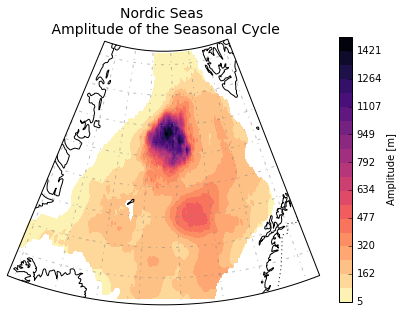

In [13]:
plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(7,5))

ax = plt.axes(projection=projection)

Map(ax, region, xtick, ytick)

contr = ax.contourf(x_n, y_n, var, levels=levels, cmap=cmap, extend='neither', transform=data_crs)
cbar = fig.colorbar(contr, ax=ax, shrink=0.95, orientation='vertical',
                    label=cb_label) 


## This plots the shape and boundary of the projection.
vertices = [(lon, lat1) for lon in range(int(lon1), int(lon2+1), 1)]+ \
           [(lon, lat2) for lon in range(int(lon2), int(lon1+1), -1)]
boundary = mpath.Path(vertices)
ax.set_boundary(boundary, transform=data_crs)


ax.set_title(fig_title, fontsize=14)

#plt.savefig(dir_o + 'Nor-p2p.png', bbox_inches='tight')
plt.show()